# Modeling Tweets

We model the quality of tweets as well as the likelihood of a tweet to contain news. To acheive this we train multiple binary classifiers.

#### 1. Feature Creation

- social
    - user
    - content
- lexical
- semantic
    
#### 2. Setup Pipeline
- Multinomial Naive Bayes
    - 
- K Nearest Neighbor
    - 
- Decision Tree
    - Decision trees learn branching rules from features.
- Random Forest
    - A random forest is a collection of decision trees. Each tree is trained using a random sample of the dataset. The prediction is an average of all the predictions made by the trees.
- Support Vector Classifier
    - 

#### 3. Run Pipeline
- specify class to predict
    - Question (0,1)
    - Advertisement (0,1)
    - Personal Opinion (0,1)
    - Sarcasm (0,1)
    - Explicit Language or Graphic Content (0,1)
    - News (0,1)
    
*We discard those values which were annotated as unclear and model on those which were identified as news or non-news content. This clearer sepearation in our data increase the accuracy of the model, although requires more data to be annotated.*
    
#### 4. Evaluation
- interpret results
    - Accuracy
        - Classification accuracy is the number of correct predictions made divided by the total number of predictions made. This is studied as the jaccard similarity score.
    - Precision
        - fraction of correctly predictive positives to all predicted as positives: $\frac{true positives}{true postivies + false positives}$
    - Recall
        - fraction of correctly predicted positives to all positives: $\frac{true posisitves}{true positives + false negatives}$
    - F1 Score
        - weighted average of precision and recall, from 0 to 1: $\frac{2 \cdot (precision \cdot recall)}{precision + recall}$

Accepting certain results from the above can depend on application. Specifically, we try to combat the [**accuracy paradox**](https://en.wikipedia.org/wiki/Accuracy_paradox) which is relevant to datsets of unbalanced class distribution. Given a dataset of large class unbalance, the classifier will predict the dominant class majority of the time and result in high accuracy. Although this accuracry is misleading because it simply represents the underlying class distribution. Alternatively, we look at further measures of evaluation.

If the applications requires high degree of certainty for those positive predictions actually being positive then **high precsion** is most important. If the application requires the prediciton of as many positive examples as possible then **high recall** will be most important. The former application could accept some positive examples being misclassified as negative and the latter could accept some negative example being misclassified as positive.

*For the application of event summarization on Twitter, we are mostly interested in presenting only only that content which is actually important and ignoring that which is not important. Therefore we are interested in maximizing precision to be able to identify those Tweets which are actually newsworthy, and dismiss recall due to the volume of data we have access to.*

In addition to looking at precision, we apply the technique of **undersampling** to create a more balanced dataset for classifying. By simply dropping some of data from the dominant class we can boost the representation of the underrepresented class. This will in turn create a more meaninful accuracy score. This technique is available due to the volume of data we are able to annotate through crowdsourcing.

## Results

### Quality Characteristics

### News Updates


#### import tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import nltk
from nltk import TweetTokenizer
from textblob import TextBlob
from datetime import datetime

#### import data

In [85]:
df1 = pd.read_table('data/final/event_IndianaPrimary_data.txt', sep='\t', encoding='utf-8', header=0)
df2 = pd.read_table('data/final/event_ChelseavsTottenhamPremierLeagueMatch_data.txt', sep='\t', encoding='utf-8', header=0)
df3 = pd.read_table('data/final/event_WhiteHouseCorrespondentsDinner_data.txt', sep='\t', encoding='utf-8', header=0)
df4 = pd.read_table('data/final/event_GoogleIO2016_data.txt', sep='\t', encoding='utf-8', header=0)
df5 = pd.read_table('data/final/event_EgyptAirFlight804_data.txt', sep='\t', encoding='utf-8', header=0)

In [86]:
df = pd.concat([df1, df2, df3, df4, df5])
df.shape

(254491, 35)

#### import ground truth

In [87]:
cf = pd.read_table('data/final/cf_report_912746_full_FINAL.csv', sep=',', encoding='utf-8', header=0)
cf.shape

(310, 69)

#### merge ground truth with data

In [88]:
#characteristics
cf['question'] = cf['characteristics'].apply(lambda q: 1 if 'question' in [i for i in str(q).split('\n')] else 0)
cf['advertisement'] = cf['characteristics'].apply(lambda q: 1 if 'advertisement' in [i for i in str(q).split('\n')] else 0)
cf['opinion'] = cf['characteristics'].apply(lambda q: 1 if 'opinion' in [i for i in str(q).split('\n')] else 0)
cf['sarcasm'] = cf['characteristics'].apply(lambda q: 1 if 'sarcasm' in [i for i in str(q).split('\n')] else 0)
cf['explicit'] = cf['characteristics'].apply(lambda q: 1 if 'explicit' in [i for i in str(q).split('\n')] else 0)
cf['error'] = cf['characteristics'].apply(lambda q: 1 if 'error' in [i for i in str(q).split('\n')] else 0)
cf['none'] = cf['characteristics'].isnull().apply(lambda q: 1 if q == True else 0)
#news
#news location
cf['news_in_text'] = cf['news_location'].apply(lambda q: 1 if 'text' in [i for i in str(q).split('\n')] else 0)
cf['news_in_media'] = cf['news_location'].apply(lambda q: 1 if 'media' in [i for i in str(q).split('\n')] else 0)
cf['news_in_link'] = cf['news_location'].apply(lambda q: 1 if 'link' in [i for i in str(q).split('\n')] else 0)

#### handle duplicates in crowdflower (something went wrong)
- replace with aggregation here

In [89]:
#cf.groupby(['event', 'master_id']).size().sort_values(ascending=False).head()
cf = cf.drop_duplicates(['event', 'master_id'], keep='first')

In [99]:
cf.groupby(['event', 'master_id']).size().sort_values(ascending=False).head()

event                               master_id
White House Correspondents' Dinner  73608        1
EgyptAir Flight 804                 45999        1
                                    44541        1
                                    44856        1
                                    45116        1
dtype: int64

In [90]:
cf.shape

(278, 79)

47.48% (132 docs) of data marked with quality characteristics:

co occurences:
               question  advertisement  opinion  sarcasm  explicit  error
question             19              1        1        4         0      0
advertisement         1              9        1        0         0      0
opinion               1              1       81        9         2      0
sarcasm               4              0        9       28         0      0
explicit              0              0        2        0         6      0
error                 0              0        0        0         0      6

% co occurences:


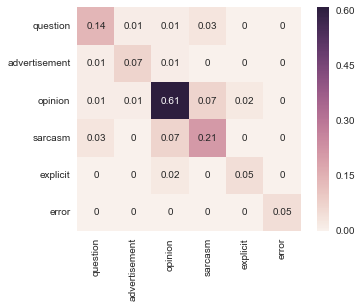

In [91]:
n = cf.shape[0]
k = cf[cf['characteristics'].notnull()].shape[0]
print('%.2f%% (%s docs) of data marked with quality characteristics:' % ((k/n*100), k))
print()
print('co occurences:')
x = cf[['question', 'advertisement', 'opinion', 'sarcasm', 'explicit', 'error']]
#dot product of matrix transpose and matrix
x = x.astype(int)
x = x.T.dot(x)
print(x)
print()
print('% co occurences:')
ax = sns.heatmap(round(x/k, 2), annot=True, square=True)
sns.plt.show()

   news  count   percent
0   0.0    175  0.629496
1   1.0     57  0.205036
2   0.5     45  0.161871

of those markes news or maybe news:

  news location  count   percent
0          text     88  0.316547
1         media     28  0.100719
2          link      0  0.000000

news with characteristics breakdown:

     question advertisement opinion sarcasm explicit error none
          sum           sum     sum     sum      sum   sum  sum
news                                                           
0.0        16             9      67      23        5     5   63
0.5         0             0      11       4        1     0   32
1.0         3             0       3       1        0     0   51


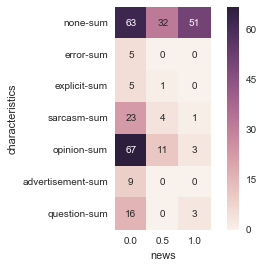

In [92]:
x = pd.concat([cf['news'].value_counts(), cf['news'].value_counts(normalize=True)], axis=1)
x = x.reset_index()
x.columns = ['news', 'count', 'percent']
print(x)

print()
print('of those markes news or maybe news:')
print()
x = pd.DataFrame([['text',cf['news_in_text'].sum()],
                  ['media',cf['news_in_media'].sum()],
                  ['link',cf['news_in_link'].sum()]],
                 columns=['news location', 'count'])
n = cf.shape[0]
x['percent'] = x['count'] / n
print(x)

print()
print('news with characteristics breakdown:')
print()
x = cf.groupby('news').agg(['sum'])[['question', 'advertisement', 'opinion', 'sarcasm', 'explicit', 'error', 'none']]
print(x)
ax = sns.heatmap(x.T, annot=True, square=True)
ax.invert_yaxis()
sns.axlabel('news', 'characteristics')
sns.plt.show()

In [93]:
print('News Updates per Event:')
print()
print(cf[cf['news']==1]['event'].value_counts())

News Updates per Event:

EgyptAir Flight 804                           19
Google I/O 2016                               14
Indiana Primary                               11
Chelsea vs. Tottenham Premier League Match    10
White House Correspondents' Dinner             3
Name: event, dtype: int64


In [101]:
cols = ['event',
        'master_id',
        'text',
        'question',
        'advertisement',
        'opinion',
        'sarcasm',
        'explicit',
        'news']

In [102]:
df_annotated = cf[cols].fillna(0)

In [103]:
df_annotated.columns = ['event',
                        'master_id',
                        'text',
                        'y_question',
                        'y_advertisement',
                        'y_opinion',
                        'y_sarcasm',
                        'y_explicit',
                        'y_news']

In [106]:
df = pd.merge(df, df_annotated, how='inner', on=['event', 'master_id', 'text'])
df.shape

(278, 41)

## feature creation

#### clean text

In [107]:
#make sure to handle text as string
df['text'] = df['text'].astype('str')
#remove links
df['text_clean'] = df['text'].apply(lambda text: ' '.join([(w[:w.find('http')] if 'http' in w else w) for w in text.split()]))
#remove hashtag symbol
df['text_clean'] = df['text_clean'].apply(lambda text: text.replace('#', ''))
#remove mention symbol
df['text_clean'] = df['text_clean'].apply(lambda text: text.replace('@', ''))
#initiate, apply tokenization
tknzr = TweetTokenizer()
df['text_clean'] = df['text_clean'].apply(lambda s: ' '.join([w.lower() for w in tknzr.tokenize(str(s))]))

#### features
- some are pulled from existing twitter data
- some created
    - social
        - content
            - tweet_type
            - possibly_sensitive
            - is_retweet
            - is_reply
            - is_quoted_tweet
            - favorite_count
            - retweet_count
            - count_entities_media
            - count_entities_urls
            - count_entities_mentions
            - count_entities_hashtags
        - user
            - user_default_profile
            - user_default_profile_image
            - user_verified
            - user_statuses
            - user_favourites
            - user_followers
            - user_friends
            - user_listed
            - user_bio_len
            - user_reputation
            - user_age_days
            - user_follower_rate
    - lexical
        - count_characters
        - count_non_characters
        - count_upper
        - count_tokens
        - count_stops
        - question
        - elongation
        - ellipsis
        - lexical_diversity
        - sfpp
        - pfpp
        - pos_cnt
        - nes_cnt
    - semantic
        - text_sentiment_negative
        - text_sentiment_positive
        - text_sentiment_subjective
        - topk_terms_coverage
        - tfidf_sum
        - tfidf_mean
        - event_centroid_distance

#### tweet features

In [108]:
df['tweet_type'] = df['tweet_type'].apply(lambda d: [0,1][d=='media']) #1=media, 0=text
df['possibly_sensitive'] = df['possibly_sensitive'].apply(lambda d: [0,1][d==True])
df['count_entities_media'] = df['entities_media'].apply(lambda media: len(media))
df['count_entities_urls'] = df['entities_urls'].apply(lambda urls: len(urls))
df['count_entities_mentions'] = df['entities_mentions'].apply(lambda mentions: len(mentions))
df['count_entities_hashtags'] = df['entities_hashtags'].apply(lambda tags: len(tags))

#### user features

In [109]:
df['user_bio_len'] = df['user_description'].apply(lambda bio: len(str(bio)))
df['user_verified'] = df['user_verified'].apply(lambda d: [0,1][d==True])
df['user_default_profile'] = df['user_default_profile'].apply(lambda d: [0,1][d==True])
df['user_default_profile_image'] = df['user_default_profile_image'].apply(lambda d: [0,1][d==True])
df['user_reputation'] = df['user_followers'] / (df['user_friends'])
df['user_reputation'].replace(np.inf, np.nan, inplace=True)
df['user_age_days'] = df['user_created_at'].apply(lambda created_at: (datetime.today() - pd.to_datetime(created_at)).days)
df['user_follower_rate'] = df['user_followers'] / df['user_age_days']
df['user_follower_rate'].replace(np.inf, np.nan, inplace=True)

#### tweet features

In [110]:
df['count_characters'] = df['text'].apply(lambda text: len(str(text)))
df['count_non_characters'] = df['text'].apply(lambda text: len(re.sub('[\w+!@#$%&;:,.?\/\-“”’`"\'()|]', '', text).strip()))
df['count_upper'] = df['text'].apply(lambda text: len([l for l in ' '.join([w for w in text.split() if not w.startswith(('#', '@'))]) if l.isupper()]))
df['count_tokens'] = df['text_clean'].apply(lambda text: len([w for w in text.split()]))
#create stop word list
stop = nltk.corpus.stopwords.words('english')
df['count_stops'] = df['text_clean'].head().apply(lambda text: len([t for t in text.split() if t in stop]))
df['question'] = df['text_clean'].apply(lambda text: 1 if '?' in text else 0)
#create elongation regular expression match
elongated = re.compile('([a-zA-Z])\\1{3,}')
df['elongation'] = df['text_clean'].apply(lambda text: 1 if bool(elongated.search(text)) else 0)
df['ellipsis'] = df['text_clean'].apply(lambda text: 1 if any(x in text for x in ('...', '…')) else 0)
df['lexical_diversity'] = df['text_clean'].apply(lambda text: len(set(text.split())) / len(text.split()))
# singular first person pronoun
sfpp = ['i', 'i\'m', 'me', 'mine', 'my', 'myself']
df['sfpp'] = df['text_clean'].apply(lambda text: 1 if any(t.lower() in sfpp for t in text.split()) else 0)
# plural first person pronoun
pfpp = ['we', 'we\'re', 'ours', 'our', 'ourselves']
df['pfpp'] = df['text_clean'].apply(lambda text: 1 if any(t.lower() in pfpp for t in text.split()) else 0)

#### event features (semantic)

In [111]:
df['text_sentiment_polarity'] = df['text_clean'].apply(lambda text: TextBlob(str(text)).sentiment.polarity)
#convert to binary
df['text_sentiment_negative'] = df['text_sentiment_polarity'].apply(lambda s: [0,1][s < -0.5])
df['text_sentiment_positive'] = df['text_sentiment_polarity'].apply(lambda s: [0,1][s > 0.5])

df['text_sentiment_subjectivity'] = df['text_clean'].apply(lambda text: TextBlob(str(text)).sentiment.subjectivity)
#convert to binary
df['text_sentiment_subjective'] = df['text_sentiment_subjectivity'].apply(lambda s: [0,1][s > 0.5])

#### terms coverage

In [112]:
#get query grams
#query_terms = df['query'].unique()
#df['query_grams_coverage'] = df['text_clean'].apply(lambda text: len([token for token in text.split() if token.lower() in query_terms]) / len(query_terms))
#compress series of tweet texts to list
tweets = [ str(d) for d in df[df['is_retweet'] == False]['text_clean']]
#extract tokens as list
tokens = [ w for t in tweets for w in t.split()]
#construct term counter
for w in [tokens]:
    termcounts = Counter(w)
#save top k = 100 most frequent terms
topk_terms = termcounts.most_common(100)
df['topk_terms_coverage'] = df['text_clean'].apply(lambda text: len([token for token in text.split() if token.lower() in topk_terms]) / len(topk_terms))

#### tfidf

In [123]:
#use only non retweets for bag of words statistics
df_nonrt = df[df['is_retweet'] == False][['event', 'master_id', 'text_clean']]
#reset index for merging with sparse matrix
df_nonrt = df_nonrt.reset_index(drop=True)

In [124]:
#initialize sklearn vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
#create matrix of tfidf counts
#not considering retweets, due to redundancy skew
Xtfidf = tfidf_vectorizer.fit_transform(df_nonrt['text_clean'])

In [125]:
#get mean tfidf for each doc
Xtfidf_means = Xtfidf.mean(axis=1)
df_tfidf_means = pd.DataFrame(Xtfidf_means, columns=['tfidf_mean'])
#get sum tfidf for each doc
Xtfidf_sums = Xtfidf.sum(axis=1)
df_tfidf_sums = pd.DataFrame(Xtfidf_sums, columns=['tfidf_sum'])

In [126]:
df_tfidf_stats = pd.concat([df_tfidf_means, df_tfidf_sums], axis=1)

In [127]:
#join tfidf sum, mean to ids
df_nonrt = pd.merge(df_nonrt, df_tfidf_stats, how='inner', left_index=True, right_index=True)
#join back to full datatset
df = pd.merge(df, df_nonrt[['event', 'master_id', 'tfidf_sum', 'tfidf_mean']], how='inner', on=['event', 'master_id'])
df.shape

(278, 69)

#### event centroid distance

In [128]:
#calculate event centroid using tfidf mean of all columns (1000 top terms)
Xtfidf_centroid = Xtfidf.mean(axis=0)

In [129]:
#compute pairwise distance for each doc to centroid using cosine similarity equation
Xtfidf_centroid_cosdistance = pairwise_distances(X=Xtfidf, Y=Xtfidf_centroid, metric='cosine')

In [130]:
df_centroid_distance = pd.DataFrame(Xtfidf_centroid_cosdistance, columns=['event_centroid_distance'])

In [131]:
#join centroid distance to ids
df_nonrt = pd.merge(df_nonrt, df_centroid_distance, how='inner', left_index=True, right_index=True)
#join back to full datatset
df = pd.merge(df, df_nonrt[['event', 'master_id', 'event_centroid_distance']], how='inner', on=['event', 'master_id'])
df.shape

#### parts of speech, named entities
- print percent complete
- run time

In [134]:
%%time
#classify parts of speech, named entities using nltk classifier
#aggregate pos, ne counts, add counts and dictionary of parts/entities to database
#this is a slow process, should be redesigned
df_nespos = pd.DataFrame()

#define function for nltk tree mining
def getnes(tree):
    ne = []
    for node in tree:
        if type(node) is nltk.Tree:
            label = node.label()
            s = ''
            for node in node:
                s = (s + ' ' + node[0].lower()).lstrip()
            ne.append([label, s])
    return ne

complete_last = 0
for i,doc in df.iterrows():
    
    complete = round((i/df.shape[0])*100)
    if complete != complete_last:
        if complete % 2 == 0:
            print('%s%%' % complete)
            complete_last = complete
    
    tokens = nltk.word_tokenize(str(doc['text_clean']))
    
    pos = nltk.pos_tag(tokens)
    pos_cntr = Counter(list(dict(pos).values()))
    pos_data = dict(pos_cntr)
    pos_cnt = sum(pos_data.values())
    
    tree = nltk.ne_chunk(pos)
    nes = getnes(tree)
    nes_cntr = Counter(list(dict(nes).keys()))
    nes_data = dict(nes_cntr)
    nes_cnt = sum(nes_data.values())
    
    row = [pos_cnt, nes_cnt, pos_data, nes_data]
    row = pd.Series(row, index=['pos_cnt', 'nes_cnt', 'pos_data', 'nes_data'])
    row = pd.DataFrame(row).T
    df_nespos = df_nespos.append(row, ignore_index=True)
    
df = pd.merge(df, df_nespos, left_index=True, right_index=True)

2.0%
4.0%
6.0%
8.0%
10.0%
12.0%
14.0%
16.0%
18.0%
20.0%
22.0%
24.0%
26.0%
28.0%
30.0%
32.0%
34.0%
36.0%
38.0%
40.0%
42.0%
44.0%
46.0%
48.0%
50.0%
52.0%
54.0%
56.0%
58.0%
60.0%
62.0%
64.0%
66.0%
68.0%
70.0%
72.0%
74.0%
76.0%
78.0%
80.0%
82.0%
84.0%
86.0%
88.0%
90.0%
92.0%
94.0%
96.0%
98.0%
100.0%
Wall time: 50.4 s


#### convert pos counts to features
- print percent complete
- run time

In [135]:
%%time
#get all parts of speach counts, add as features
all_pos = []
for i,doc in df.iterrows():
    all_pos.extend(list(doc['pos_data'].keys()))

#get unique pos types
all_pos = list(set(all_pos))

#create pos feature df
df_pos = pd.DataFrame()
pos_cols = ['pos_cnt_'+pos for pos in all_pos] 

#update pos counts
complete_last = 0
for i,doc in df.iterrows():    
    
    complete = round((i/df.shape[0])*100)
    if complete != complete_last:
        if complete % 2 == 0:
            print('%s%%' % complete)
            complete_last = complete
    
    #create empty dictionary with keys
    pos_dict = dict.fromkeys(all_pos)
    
    for pos in doc['pos_data'].keys():
        pos_dict[pos] = doc['pos_data'].get(pos)
    
    row = list(pos_dict.values())
    row = pd.Series(row, index=pos_cols)
    row = pd.DataFrame(row).T
    df_pos = df_pos.append(row, ignore_index=True)
    
df = pd.merge(df, df_pos, left_index=True, right_index=True)

2.0%
4.0%
6.0%
8.0%
10.0%
12.0%
14.0%
16.0%
18.0%
20.0%
22.0%
24.0%
26.0%
28.0%
30.0%
32.0%
34.0%
36.0%
38.0%
40.0%
42.0%
44.0%
46.0%
48.0%
50.0%
52.0%
54.0%
56.0%
58.0%
60.0%
62.0%
64.0%
66.0%
68.0%
70.0%
72.0%
74.0%
76.0%
78.0%
80.0%
82.0%
84.0%
86.0%
88.0%
90.0%
92.0%
94.0%
96.0%
98.0%
100.0%
Wall time: 747 ms


#### convert ne counts to features
- print percent complete
- run time

In [136]:
%%time
#get all named entities counts, add as features
all_nes = []
for i,doc in df.iterrows():
    all_nes.extend(list(doc['nes_data'].keys()))

#get unique
all_nes = list(set(all_nes))

#create nes feature df
df_nes = pd.DataFrame()
ne_cols = ['ne_cnt_'+ne for ne in all_nes] 
    
#update pos counts
complete_last = 0
for i,doc in df.iterrows():    
    
    complete = round((i/df.shape[0])*100)
    if complete != complete_last:
        if complete % 2 == 0:
            print('%s%%' % complete)
            complete_last = complete
    
    #create empty dictionary with keys
    nes_dict = dict.fromkeys(all_nes)
    
    for ne in doc['nes_data'].keys():
        nes_dict[ne] = doc['nes_data'].get(ne)
    
    row = list(nes_dict.values())
    row = pd.Series(row, index=ne_cols)
    row = pd.DataFrame(row).T
    df_nes = df_nes.append(row, ignore_index=True)
    
df = pd.merge(df, df_nes, left_index=True, right_index=True)

2.0%
4.0%
6.0%
8.0%
10.0%
12.0%
14.0%
16.0%
18.0%
20.0%
22.0%
24.0%
26.0%
28.0%
30.0%
32.0%
34.0%
36.0%
38.0%
40.0%
42.0%
44.0%
46.0%
48.0%
50.0%
52.0%
54.0%
56.0%
58.0%
60.0%
62.0%
64.0%
66.0%
68.0%
70.0%
72.0%
74.0%
76.0%
78.0%
80.0%
82.0%
84.0%
86.0%
88.0%
90.0%
92.0%
94.0%
96.0%
98.0%
100.0%
Wall time: 1.14 s


In [142]:
df.shape

(278, 114)

In [143]:
df.head(1)

,master_id,twitter_id,created_at,source,longitude,latitude,place_country,place_name,text,lang,...,pos_cnt_UH,pos_cnt_WDT,pos_cnt_PRP$,pos_cnt_VBP,pos_cnt_IN,pos_cnt_RB,pos_cnt_),pos_cnt_MD,ne_cnt_ORGANIZATION,event_centroid_distance
0,1683,727118185657458688,2016-05-02 12:50:59,Linkis.com,NaN,NaN,NaN,NaN,"poll: reversal of fortune, #trump (+15) tops c...",en,...,NaN,1.0,2.0,1.0,NaN,1.0,NaN,6.0,NaN,0.831746


In [144]:
x = [
 'tweet_type',
 'possibly_sensitive',
 'is_retweet',
 'is_reply',
 'is_quoted_tweet',
 'favorite_count',
 'retweet_count',
 'user_default_profile',
 'user_default_profile_image',
 'user_verified',
 'user_statuses',
 'user_favourites',
 'user_followers',
 'user_friends',
 'user_listed',
 'user_bio_len',
 'user_reputation',
 'user_age_days',
 'user_follower_rate',
 'count_entities_media',
 'count_entities_urls',
 'count_entities_mentions',
 'count_entities_hashtags',
 'count_characters',
 'count_non_characters',
 'count_upper',
 'count_tokens',
 'count_stops',
 'question',
 'elongation',
 'ellipsis',
 'lexical_diversity',
 'sfpp',
 'pfpp',
 'text_sentiment_negative',
 'text_sentiment_positive',
 'text_sentiment_subjective',
 'topk_terms_coverage',
 'tfidf_sum',
 'tfidf_mean',
 'event_centroid_distance',
 'pos_cnt',
 'nes_cnt',
 'pos_cnt_MD',
 'pos_cnt_(',
 'pos_cnt_,',
 'pos_cnt_WDT',
 'pos_cnt_PDT',
 'pos_cnt_JJS',
 'pos_cnt_VBD',
 'pos_cnt_RB',
 'pos_cnt_DT',
 'pos_cnt_VB',
 'pos_cnt_VBP',
 'pos_cnt_VBG',
 'pos_cnt_.',
 'pos_cnt_TO',
 'pos_cnt_EX',
 'pos_cnt_IN',
 'pos_cnt_NNP',
 'pos_cnt_VBN',
 'pos_cnt_NN',
 'pos_cnt_WP',
 'pos_cnt_RP',
 'pos_cnt_VBZ',
 'pos_cnt_``',
 'pos_cnt_)',
 'pos_cnt_NNS',
 'pos_cnt_PRP',
 'pos_cnt_UH',
 'pos_cnt_:',
 'pos_cnt_JJR',
 'pos_cnt_RBS',
 'pos_cnt_WRB',
 'pos_cnt_JJ',
 'pos_cnt_CC',
 'pos_cnt_POS',
 'pos_cnt_CD',
 'pos_cnt_PRP$']

#### fill NaN

In [145]:
df[x] = df[x].fillna(0)

#### save data

In [ ]:
#save event data with features
df.to_csv('data/final/event_indianaprimary_data_train.txt', sep='\t', encoding='utf-8', header=True, index=False)

# Modeling

In [146]:
from time import time
import sklearn
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline

In [147]:
#import plotting library
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [148]:
df.shape

(278, 114)

#### setup pipeline

In [214]:
def execute(clf, y):
    print('_' * 40)
    clf_descr = str(clf).split('(')[0]
    print('>>> ', clf_descr)
    print('_' * 40)
    
    print('Training:')
    t0 = time()
    clf.fit(train[x], train[y])
    train_time = time() - t0
    print('  train time: %0.3fs' % train_time)
    
    t0 = time()
    pred = clf.predict(test[x])
    test_time = time() - t0
    print('  test time:  %0.3fs' % test_time)
    
    print()
    acc = metrics.accuracy_score(test[y], pred)
    print('Accuracy: %0.3f' % acc)
    print()
    auc = metrics.roc_auc_score(test[y], pred)
    print('ROC AUC: %0.3f' % auc)
    print()
    print('Confusion Matrix: \n', pd.crosstab(test[y], pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
    print()
    print('Report: \n', metrics.classification_report(test[y], pred))
    
    precision = metrics.precision_score(test[y], pred)
    print('Precision: %0.3f' % precision)
    recall = metrics.recall_score(test[y], pred)
    print('Recall: %0.3f' % recall)
    avg_precision = metrics.average_precision_score(test[y], pred, average='macro')
    print('Class-Weighted AVG Precision: %0.3f' % avg_precision)
    
    top5 = []
    if clf_descr in ['DecisionTreeClassifier', 'RandomForestClassifier']:
        #top feature indices
        k = 5
        for i in np.argsort(clf.feature_importances_)[::-1][:k]:
            top5.append([x[i], clf.feature_importances_[i]])
        print('Top Features:')
        print(top5)
    
    return clf_descr, acc, auc, precision, recall, avg_precision, train_time, test_time, top5

#### run pipeline

In [217]:
ys = [
#'y_question',
#'y_advertisement',
#'y_opinion',
#'y_sarcasm',
#'y_explicit',
'y_news'
]

results = []

for y in ys:
    print(y.upper())
    print()
    data = df[df[y].isin([0,1])]
    train, test = train_test_split(data, test_size=.2, random_state=2016) 
    print('Class Distribution:')
    for d,name in ((data, 'Total'), (train, 'Train'), (test, 'Test')):
        t = len(d)
        n = len(d[d[y]==0])
        s = len(d[d[y]==1])
        print(name, '\t', '0: %4.0f (%0.2f%%)' % (n, (n/t)), '  ', '1: %4.0f (%0.2f%%)' % (s, (s/t)))
    print()
    print('=' * 60)
    
    for clf in (MultinomialNB(), 
                KNeighborsClassifier(),
                DecisionTreeClassifier(random_state=2016),
                RandomForestClassifier(random_state=2016),
                svm.SVC()
               ):
        results.append(execute(clf, y))

Y_NEWS

Class Distribution:
Total 	 0:  176 (0.76%)    1:   57 (0.24%)
Train 	 0:  140 (0.75%)    1:   46 (0.25%)
Test 	 0:   36 (0.77%)    1:   11 (0.23%)

________________________________________
>>>  MultinomialNB
________________________________________
Training:
  train time: 0.002s
  test time:  0.001s

Accuracy: 0.745

ROC AUC: 0.581

Confusion Matrix: 
 Predicted  0.0  1.0  All
Actual                  
0.0         32    4   36
1.0          8    3   11
All         40    7   47

Report: 
              precision    recall  f1-score   support

        0.0       0.80      0.89      0.84        36
        1.0       0.43      0.27      0.33        11

avg / total       0.71      0.74      0.72        47

Precision: 0.429
Recall: 0.273
Class-Weighted AVG Precision: 0.436
________________________________________
>>>  KNeighborsClassifier
________________________________________
Training:
  train time: 0.002s
  test time:  0.003s

Accuracy: 0.745

ROC AUC: 0.549

Confusion Matrix: 
 Pred

c:\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Naive Bayes
- Multinomial Naive Bayes significantly outperforms Gaussian model. Although Multinomial requires non-negative features, and therefore sentiment features were left out of custom feature model.

#### bag of words

In [ ]:
clf_pipe = Pipeline([('count_vect', CountVectorizer()), 
                     ('X_tfidf', TfidfTransformer()), 
                     ('classifier', MultinomialNB())])

MNB_tfidf = clf_pipe.fit(train['text'], train_actual)

In [ ]:
print('MNB TFIDF - Multinomial Naive Bayes using Bag of Words:')
print()
run_report(test['text'], test_update, MNB_tfidf)

#### custom features

## K Nearest Neighbor

## Decision Tree

## Random Forest

## Support Vector Machine